In this blog, we have a look at how philosophers from different era and schools wrote their most famous texts. For instance, we will have a look at how their emotions influence their writing, which words each of them used the most and in which context are they using this words, as well as the topics that are covered in their books. 

# Step 0 : Load the necessary libraries

First let's install and load the necessary libraries for this blog and set up a logging to monitor our diverse methods.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from nrclex import NRCLex
from sklearn import decomposition
from sklearn import cluster
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE
import gensim
import nltk
from spacy import load
import re  # For preprocessing
import multiprocessing
import time
import random

cores = multiprocessing.cpu_count()
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
sns.set_style("darkgrid")

# Step 1 : Load the Data 

Now once all of the required librairies are downloaded, we shoud load our data set into a Pandas data frame.

In [3]:
philosophy_sentences = pd.read_csv("C:/Users/aroni/Documents/STATGR5243/Project_1/spring-2022-prj1-clement-micol/data/philosophy_data.csv")

Let's have a look at the first 5 rows of our data. We can see that each row correspond to a sentence written from a philosopher. We have acces to the title, the original publication and the corpus edition date of the book from which the sentence was extracted. We also have access to name of the author and its school of philosophy. Moreover, each sentence has already been preprocessed into a tokenized version and a lemmatized version of the text. We will see that this preprocessing need some more tuning.

In [4]:
philosophy_sentences.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


For our future analysis to be relevant and avoid one author to be predominant in the corpus, we have a look at how many words each author has in this corpus of texts.

Text(0.5, 1.0, 'Number of words per author in the corpus')

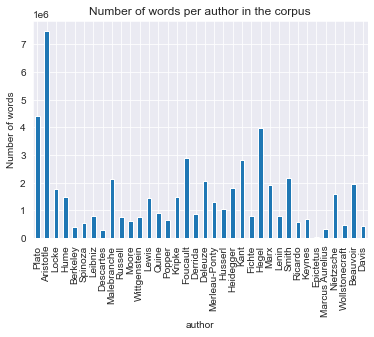

In [5]:
# We get the number of words per author
number_of_words = philosophy_sentences.groupby("author",sort=False).sentence_length.sum() 
# We plot the number of words per author
number_of_words.plot.bar()
plt.ylabel("Number of words")
plt.title("Number of words per author in the corpus")

Text(0.5, 1.0, 'Number of words per author in the corpus')

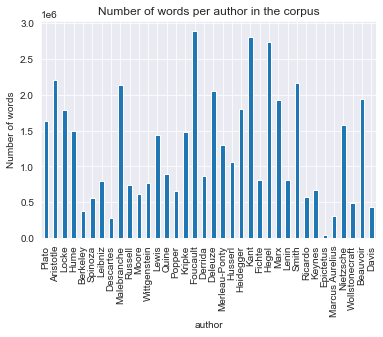

In [6]:
#We remove some sentences from Plato, Aristotle and Hegel

philosophy_sentences = philosophy_sentences.drop(philosophy_sentences[philosophy_sentences["author"] == "Plato"].index[15000:])
philosophy_sentences = philosophy_sentences.drop(philosophy_sentences[philosophy_sentences["author"]=="Aristotle"].index[15000:])
philosophy_sentences = philosophy_sentences.drop(philosophy_sentences[philosophy_sentences["author"]=="Hegel"].index[15000:])

# We plot again the number of words per author

philosophy_sentences.groupby("author",sort=False).sentence_length.sum().plot.bar()
plt.ylabel("Number of words")
plt.title("Number of words per author in the corpus")

# Step 2 : A first exploration of the data set

As a first exploration, we see if it is relevant to look only at the first publication of each author. The following figure shows that 70% of the words from this corpus are from the first book of one author and 20 of the 36 authors only have 1 publication in the corpus. Looking only at the first publication of each author would reduce drastically the size of our corpus but it would come with a huge loss of information ($\sim 30\%$). So in the rest of the blog, we will look at the whole corpus.

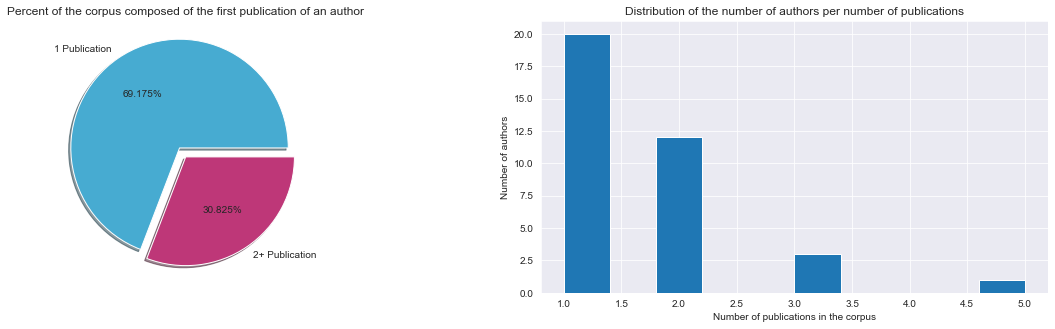

In [124]:
# We calculate the number of words in each publication and the total number of words in the corpus
Number_Of_Words_per_publication = philosophy_sentences.sort_values("original_publication_date").groupby(["author","title"],sort=False).sentence_length.sum()
Number_Of_Words = Number_Of_Words_per_publication.sum()

# We compute the percentage of the corpus that is from the first publication of an author

fig, axs = plt.subplots(1,2)
Percent_of_1st_publication = 0
for author in philosophy_sentences["author"].unique():
    Percent_of_1st_publication += Number_Of_Words_per_publication[author][0]/Number_Of_Words

# We plot in a pie chart the percentage of the corpus that is from the first publication of an author

axs[0].pie([Percent_of_1st_publication,1-Percent_of_1st_publication],
        labels=["1 Publication","2+ Publication"],
        autopct="%.3f%%", 
        colors=[[71/255,171/255,209/255],[190/255,55/255,120/255]],
        explode=[0.1,0],
        shadow=True)
axs[0].set_title("Percent of the corpus composed of the first publication of an author")

# We get the number of publication per author
Number_Of_Parutions = philosophy_sentences.groupby("author").title.apply(lambda x: len(np.unique(x)))

# Plot it in an histogram
Number_Of_Parutions.hist(ax=axs[1])
axs[1].set_title("Distribution of the number of authors per number of publications")
axs[1].set_xlabel("Number of publications in the corpus")
axs[1].set_ylabel("Number of authors")
plt.show()

One of the first analysis we can do to understand the way of writing of a philosopher is to look at the average length of its sentences. In the first Figure, the philosophs are sorted by their publication dates. We can't detect a clear trend in the evolution of the sentences length over the years even though it seems that the ancient Greek philosophers wrote in average smaller sentences in comparaison to the more contemporary philosopher. In average, a philosopher writes sentences of 140 words but some stands out from the rest by their writing style. Descartes' style for instance is marked by very long sentences on average as opposed to Wittgenstein whose writing style is characterized by small sentences. Deleuze wrote the most intracted and complex sentence of the corpus with a total of 2649 words (long enumeration and description within parenthesis).

In [677]:
longest_sentence = philosophy_sentences[philosophy_sentences["sentence_length"]==2649]["sentence_str"]
print("Longest sentence of the corpus :\n")
print(longest_sentence[219085])

Longest sentence of the corpus :

We have seen on what foundations this aggregate operated: a whole field of immanence that is reproduced on an always larger scale, that is continually multiplying its axioms to suit its needs, that is filled with images and with images of images, through which desire is determined to desire its own repression (imperialism); an unprecedented decoding and deterritorialization, which institutes a combination as a system of differential relations between the decoded and deterritorialized flows, in such a way that social inscription and repression no longer even need to bear directly upon bodies and persons, but on the contrary precede them (axiomatic: regulation and application); a surplus value determined as a surplus value of flux, whose extortion is not brought about by a simple arithmetical difference between two quantities that are homogeneous and belong to the same code, but precisely by differential relations between heterogeneous magnitudes that ar

Text(0.5, 1.0, 'Average sentences length for each authors')

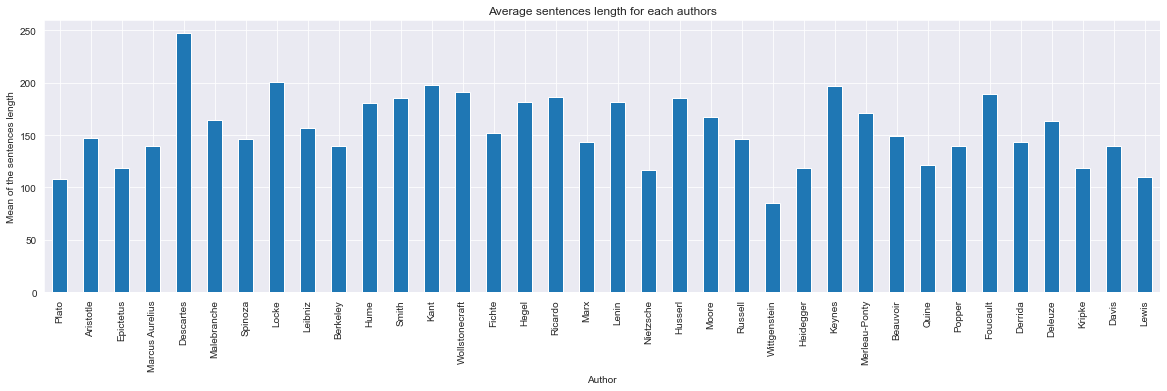

In [125]:
plt.rcParams["figure.figsize"] = (20,5)
# Get the average sentences lenght per author
sentences_length = philosophy_sentences.sort_values(["original_publication_date"]).groupby("author", sort=False)["sentence_length"].mean()
# Plot it!
sentences_length.plot.bar()
plt.ylabel("Mean of the sentences length")
plt.xlabel("Author")
plt.title("Average sentences length for each authors")

INFO - 23:24:52: NumExpr defaulting to 8 threads.


<AxesSubplot:xlabel='sentence_length', ylabel='author'>

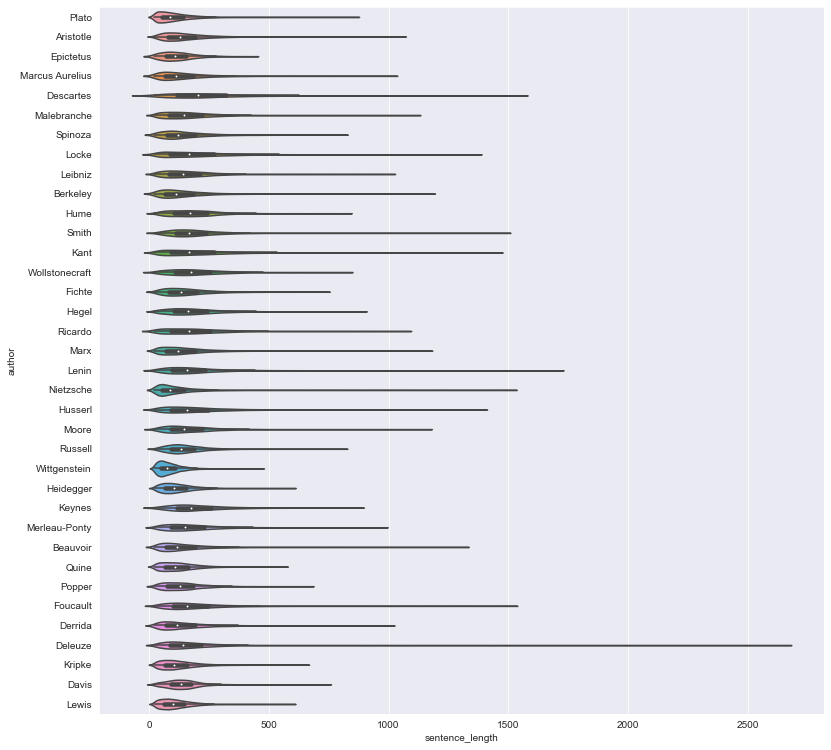

In [126]:
plt.rcParams["figure.figsize"] = (13,13)
sns.violinplot(x="sentence_length",y="author",data=philosophy_sentences.sort_values(["original_publication_date"]))

# Step 3 : A sentiment analysis of each author :

In the following section, we will try to understand the sentiments that the authors try to bring out. This would give us an idea on how philosophers use emotions to convey an idea.<br />
For sentiment analysis, a less restrictive text processing should be enforced. Indeed, stemming or using a too limiting lemmatizing process would take the emotion out of the word and bias our analysis. So we are going to use the pre-lemmatized sentences to conduct our analysis.<br />
It will be based on the NRC Lexicon to predict the emotion of the sentence. We will be dealing with the following emotions :

<function matplotlib.pyplot.show(close=None, block=None)>

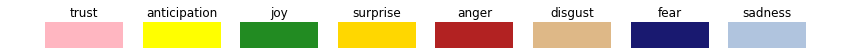

In [755]:
emotions_color = {"trust" : "lightpink", "anticipation" : "yellow", "joy" : "forestgreen", "surprise" : "gold", 
                 "anger" : "firebrick", "disgust" : "burlywood", "fear" : "midnightblue", "sadness" : "lightsteelblue"}
plt.rcParams["figure.figsize"] = (15,0.5)
my_bars = plt.bar(list(emotions_color),8*[1],color=emotions_color.values())
for i,bar in enumerate(my_bars):
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.2, list(emotions_color)[i],
                 ha='center', fontsize=12)
plt.axis("off")
plt.show

Let's have a look at how the spectrum of emotion of different philosophers evolves as we progress through the reading.

In [680]:
# Plot the evolution of the emotion aroused by each sentence as we progress
# through the reading for the specific author.

def Sequential_Emotion_Analysis(author, n):
    # This list store the evolution of the emotional level
    sequence_of_emotions_level = []
    # This list store the evolution of the emotion through the reading
    sequence_of_emotions_color = []
    # Iter through n sentences wrote by the author 
    for sentence in philosophy_sentences[philosophy_sentences["author"] == author].lemmatized_str.iloc[:n]:
        # Get the emotions aroused by the sentence from the NRC Lexicon
        emotions = NRCLex(sentence)
        # For each emotion, we get the frequency of words that aroused this emotion.
        emotion_frequencies = emotions.affect_frequencies
        # The NRC Lexicon doesn't differentiate sentiment from emotion.
        # So it may affect a sentence with a positive or negative allocation.
        # Since we are only interested in the emotion, we remove the affection
        # of position or negative.
        emotion_frequencies.pop("positive",None)
        emotion_frequencies.pop("negative",None)
        # Get the emotion that was the most aroused in this sentence.
        # We consider that is the emotion of the sentence.
        top_emotion = max(emotion_frequencies,key=emotion_frequencies.get)
        # Add the level of emotion of this sentence to the list
        sequence_of_emotions_level.append(emotion_frequencies[top_emotion])
        # Add the emotion of the sentence to the list
        sequence_of_emotions_color.append(emotions_color[top_emotion])
    # Plot the evolution of the emotions through the reading
    plt.bar(range(n), sequence_of_emotions_level, color=sequence_of_emotions_color)
    frame1 = plt.gca()
    frame1.axis('off')
    plt.title(author)
    plt.show()

We plot below the evolution of the emotion brought out by some authors over their first 1500 sentences. We see that each author goes quite broadly through the spectrum of emotions but it is the emotions trust and anticipation that stand out the most. Also they all have a different flow of emotions although the overabundance of the emotion trust suggests otherwise. For instance, Moore almost brings out only trust from his sentences. Foucault exploits abundantly the feeling of fear to convey his ideas. Aristotle has a shift in his writing by first using fear-inducing words extensively, and then using a many words that evoke sadness. Descartes has a lot of neutral or not documented sentences (in the sense that no words i the sentence are documented through the NRC Lexicon). Marx and Moore rely broadly on the emotion of trust and anticipation.

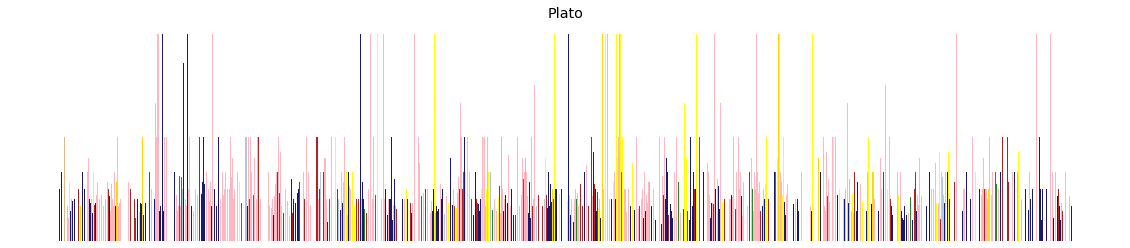

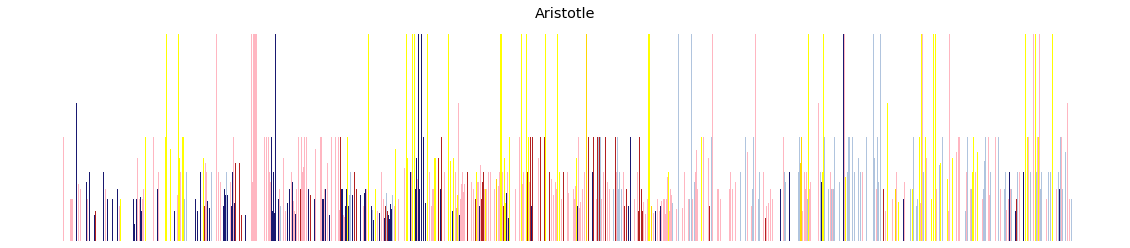

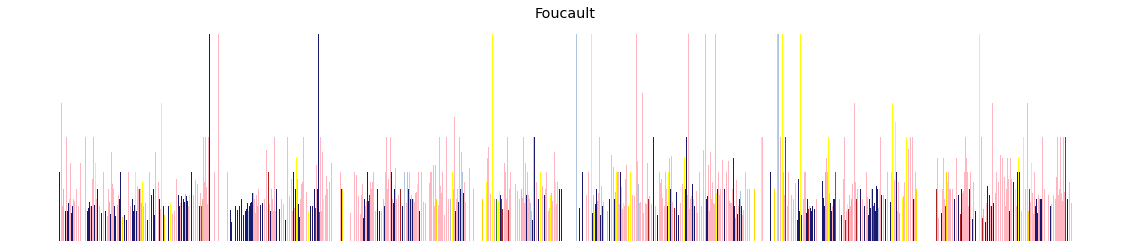

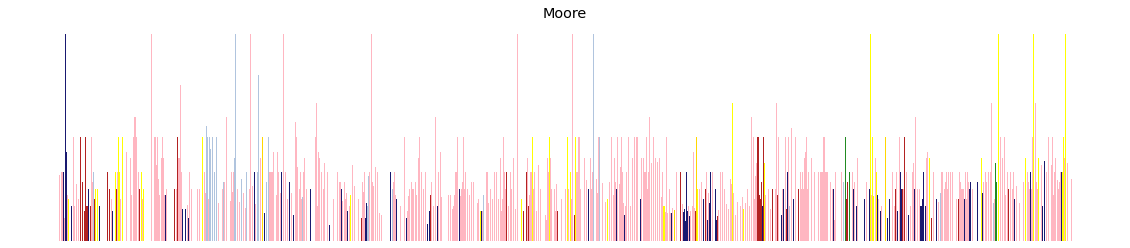

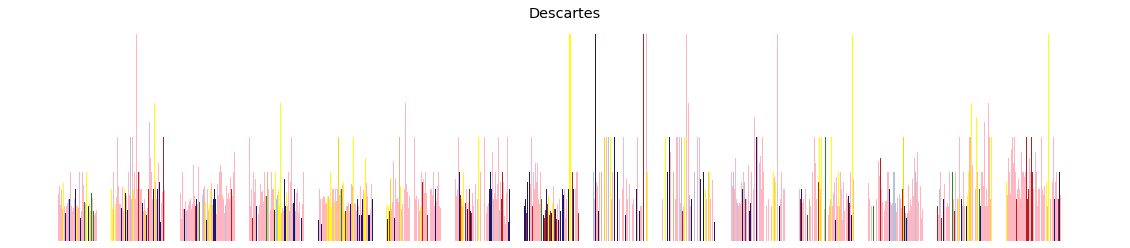

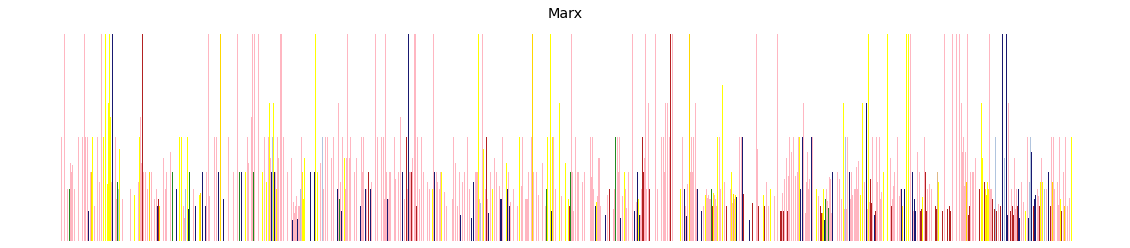

In [681]:
plt.rcParams["figure.figsize"] = (20,4)
Sequential_Emotion_Analysis("Plato",1500)
Sequential_Emotion_Analysis("Aristotle",1500)
Sequential_Emotion_Analysis("Foucault",1500)
Sequential_Emotion_Analysis("Moore",1500)
Sequential_Emotion_Analysis("Descartes",1000)
Sequential_Emotion_Analysis("Marx",1500)

To pursue our emotion analysis, let's now have a look at the percentage of emotion each author brought out overall.

In [858]:
# Retrieve the number of times each emotion has been brought out by the author.
def Emotion_Analysis(author):
    # This dictionary will be use to count the number of time each a words is affected 
    # to one of these emotions.
    emotions_level = {"anticipation" : 0, "joy" : 0, "surprise" : 0, "trust" : 0,
                "anger" : 0, "disgust" : 0, "fear" : 0, "sadness" : 0}
    # Iter through ALL of the sentences of the author
    for sentence in philosophy_sentences[philosophy_sentences["author"] == author].lemmatized_str:
        # Retrieve the emotions brought by this sentence
        emotions = NRCLex(sentence)
        # Iter over all the emotion raised in this sentence
        for emotion in emotions.raw_emotion_scores:
            if emotion in emotions_level:
                # Add the number of times this emotion was raised in this sentence
                # to our dictionary
                emotions_level[emotion] += emotions.raw_emotion_scores[emotion]
    return pd.DataFrame(emotions_level, index=[author])
# We construct a Data Frame in which a row correspond to an author and 
# a column correspond to the raw score for one emotion (i.e. the number of
# time this emotion was brought by this author).
df = pd.DataFrame(None)
# Iter over the authors
for author in philosophy_sentences.author.unique():
    # Get the raw score for each emotion for this author
    res = Emotion_Analysis(author)
    # Add it to the Data Frame
    df = pd.concat([df,res])

The figure below shows us that almost every philosopher emphasizes the most on the trust and the anticipation (or atleast according to the NRC Lexicon) which would be standard for a philosopher who is trying to convice and convey some ideas. However, there are some noticeable exceptions such as Davis whose writing style is based on more negative emotions such as fear and sadness. Foucault relies as well a lot on fear and anger. Plato, Spinoza, Wollstonecraft and Moore bring joy to a higher level than their peers.

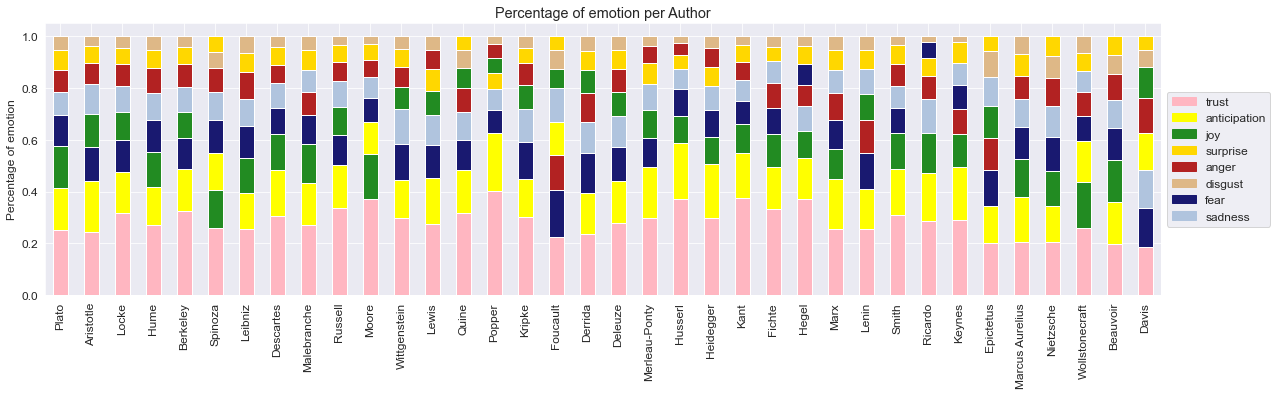

In [903]:
plt.rcParams["figure.figsize"] = (20,5)
df_copy = df.T.apply(lambda x : x/sum(x))
labels = list(df_copy)
for author in labels:
    level = df_copy[author].sort_values(ascending=False)
    for i in range(8):
        plt.bar(author, level[i], width = 0.5, bottom=sum(level[:i]), color=emotions_color[level.index[i]])
patches = [Patch(color = emotions_color[emotion]) for emotion in list(emotions_color)]
plt.legend(patches,  list(emotions_color), loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.xlim(left=-0.5,right=35.5)
plt.title("Percentage of emotion per Author")
plt.ylabel("Percentage of emotion")
df_copy = df_copy.T
plt.show()


We do a quick clustermap of the correlation between the emotions to see if there is any pattern. As expected, we have two distinct clusters from the negative emotions (anger, disgust, fear, sadness) and the positive emotions (joy, trust, anticipation, surprise). Also the two most represented emotions (trust and anticipation) are grouped in the same clusters.

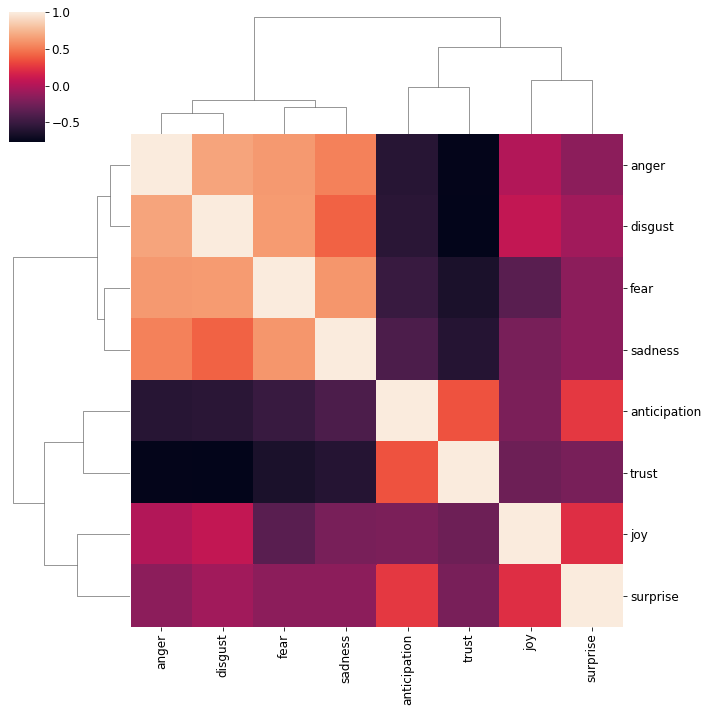

In [ ]:
sns.clustermap(df_copy.corr())

To conclude our emotional analysis, we project our constructed data consisting of the emotional score of each author into a lower dimensional space using a PCA. This way, we can visualize the distance between two authors accordig to their emotional spectrum. We then used a KMean Classifier to highlight clusters of author. The figure on the right shows the projection of the features on this same reduced space. In other terms, the authors on the most left-wing author are those who relied the most on negative emotions. The authors on the most right are those who writing style brings the most trust out of it. We can see that the emotional spectrum of an author is not necessarily linked to his school of philosophy even though two authors from the same school are likely to have a similar emotional spectrum. 

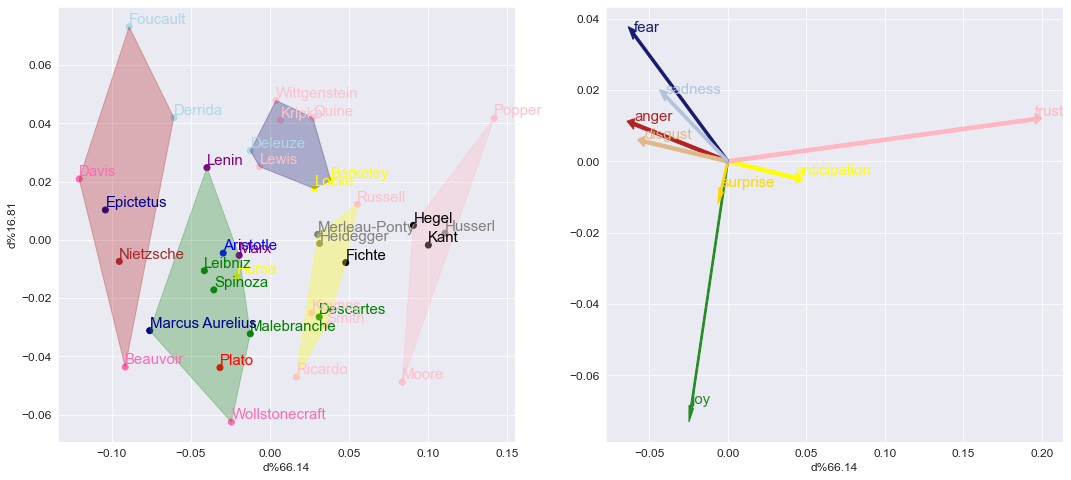

In [938]:
# Create a dictionary associating a school with a color
school_color = {'plato':"red", 'aristotle':"blue", 'empiricism':"yellow", 'rationalism':"green", 'analytic':"pink",
       'continental':"lightblue", 'phenomenology':"grey", 'german_idealism': "black", 'communism' : "purple",
       'capitalism' : "pink", 'stoicism' : "darkblue", 'nietzsche' : "brown", 'feminism' : "hotpink"}
# Get all the schools
schools = philosophy_sentences.groupby("author",sort=False).school.unique()
# Create our PCA method. We are only gonna used the first two dimensions.
PCA_Classifier = decomposition.PCA(2)
# Fit the PCA model to our structured data.
PCA_fit = pd.DataFrame(PCA_Classifier.fit_transform(df_copy), index= df.index)
# Get the explained variance of the PCA on our structured data.
Explained_Variance = PCA_Classifier.fit(df_copy).explained_variance_ratio_

# Construct the plot of the projection of our data on the first two dimensions of the PCA
plt.rcParams["figure.figsize"] = (18,8)
fig, axs = plt.subplots(1,2)
axs[0].set_xlabel("d%{:.2f}".format(100*Explained_Variance[0]))
axs[0].set_ylabel("d%{:.2f}".format(100*Explained_Variance[1]))
axs[0].scatter(PCA_fit[0],PCA_fit[1], color=schools.apply(lambda x : school_color[x[0]]))
for author in df.index:
    axs[0].text(PCA_fit[0][author],PCA_fit[1][author],author,
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=school_color[schools[author][0]],
                weight='normal'
                ).set_size(15)
# Construct the plot of the projected features of our structured data.
PCA_Explained = PCA_Classifier.fit(df_copy)
PCA_res = np.zeros([8,2])
# Iter of the features.
for i in range(8):
    # Use the duality between the individual's porjection and the features projections 
    # to get the coordinate of the feature projections.
    PCA_res[i,0] = 1/np.sqrt(PCA_Explained.singular_values_[0])*(df_copy.T).iloc[i] @ PCA_fit[0]
    PCA_res[i,1] = 1/np.sqrt(PCA_Explained.singular_values_[1])*(df_copy.T).iloc[i] @ PCA_fit[1]
    axs[1].arrow(0,0,PCA_res[i,0],PCA_res[i,1], color=emotions_color[list(df)[i]])
    axs[1].text(PCA_res[i,0],PCA_res[i,1], list(df)[i],horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=emotions_color[list(df)[i]],
                weight='normal'
                ).set_size(15)
axs[1].set_xlabel("d%{:.2f}".format(100*PCA_Explained.explained_variance_ratio_[0]))
axs[1].set_ylabel(None)

# Creating the clusters using the KMeans algorithm
random_state = 120
KMean = cluster.KMeans(n_clusters = 5, random_state=random_state, algorithm="auto")
Fitted_Cluster = KMean.fit(df_copy)
PCA_fit["cluster"] = Fitted_Cluster.predict(df_copy)
# Get the most high emotion in average over the cluster in comparaison
# to the other clusters.
emotion_per_cluster = (
    (df_copy.join(PCA_fit["cluster"])).groupby("cluster").mean()
    -(df_copy.join(PCA_fit["cluster"])).groupby("cluster").mean().mean()
    ).T.idxmax()
for i in range(5):
    points = PCA_fit[PCA_fit["cluster"] == i][[0,1]].values
    if len(points)>2 :
        hull = ConvexHull(points)
        x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
        # plot shape
        axs[0].fill(x_hull, y_hull, alpha=0.3, c=emotions_color[emotion_per_cluster[i]])
    else :
        axs[0].plot(points[:,0],points[:,1], color =emotions_color[emotion_per_cluster[i]])

# Step 5 : Topic modeling and Word embedding

In the last section, we saw that the spectrum of emotions that emanate from your text can be a defining trait of a philosopher's work. But most importantly, a philosopher's work is defined by the topic it deals with and the words related to it. So to better understand the work of these philosophers, we are going to model the topics that are addressed in this corpus using a LDA. But first and foremost, since the LDA constructs a bag of words, we need to process our data  by lemmatizing our text and removing any stopwords.

In [560]:
nlp = load("en_core_web_sm", disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
nlp.Defaults.stop_words |= {"thyself","thou","thy","unto","thee","ye"} # add new stopwords  

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

# Remove any characther that isn't a letter and retunr its lowercase version
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in philosophy_sentences['sentence_str'])


In [561]:
t = time.time()
# Clean the text
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to clean up everything: 13.22 mins


We construct a Data Frame from the processed sentences and we remove the empty line (which corresponds to the sentences with lot of stopwords and with less than two words). To facilitate the reporductibility of this blog, we save the processed sentences in a csv file. Finally, we create a tokenized version of our sentences.

In [562]:
sentences_processed = pd.Series(txt, index = philosophy_sentences["author"]) 
sentences_processed = sentences_processed.dropna().drop_duplicates()
sentences_processed = sentences_processed.str.replace("'","")
sentences_processed.to_csv("C:/Users/aroni/Documents/STATGR5243/Project_1/spring-2022-prj1-clement-micol/data/setences_processed.csv")
tokenized = sentences_processed.apply(nltk.word_tokenize)

These lines are to be run if we don't want to do the preprocessing above and load the processed sentences.

In [11]:
# Change the directory
sentences_processed = pd.read_csv("C:/Users/aroni/Documents/STATGR5243/Project_1/spring-2022-prj1-clement-micol/data/setences_processed.csv")
sentences_processed.index = sentences_processed["author"]
sentences_processed = sentences_processed["0"]
tokenized = sentences_processed.apply(nltk.word_tokenize)

Now we are ready for topic modeling. Before performing the LDA, we transform each words in a corpus in a couple $(x,y)$ where $x$ correspond to the identity number of the word in the preconstructed dictionary and $y$ refers to the number of time the word appears in the corpus.

In [12]:
sentences_processed_concat_per_author = sentences_processed.groupby("author",sort=False).apply(lambda sentence: sentence.str.cat(sep=" ")).apply(nltk.word_tokenize)
dictionary = gensim.corpora.Dictionary(sentences_processed_concat_per_author)
corpus = [dictionary.doc2bow(text) for text in sentences_processed_concat_per_author]

INFO - 23:32:29: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 23:32:30: built Dictionary(67434 unique tokens: ['abandon', 'abaris', 'abdera', 'abduct', 'abide']...) from 36 documents (total 3071238 corpus positions)
INFO - 23:32:30: Dictionary lifecycle event {'msg': "built Dictionary(67434 unique tokens: ['abandon', 'abaris', 'abdera', 'abduct', 'abide']...) from 36 documents (total 3071238 corpus positions)", 'datetime': '2022-02-07T23:32:30.950002', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


We choose 10 topics for our topic modeling. This number is big enough to cover multiple topics and small enough to facilitate the naming of each topics. Let's construct our model using LDA from the gensim package.

In [14]:
NUM_TOPICS = 10
ldamodel = gensim.models.LdaMulticore(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20, workers=4,random_state=0)

INFO - 23:33:38: using symmetric alpha at 0.1
INFO - 23:33:38: using symmetric eta at 0.1
INFO - 23:33:38: using serial LDA version on this node
INFO - 23:33:38: running online LDA training, 10 topics, 20 passes over the supplied corpus of 36 documents, updating every 8000 documents, evaluating every ~36 documents, iterating 50x with a convergence threshold of 0.001000
INFO - 23:33:38: training LDA model using 4 processes
INFO - 23:33:43: PROGRESS: pass 0, dispatched chunk #0 = documents up to #36/36, outstanding queue size 1
INFO - 23:33:44: topic #4 (0.100): 0.007*"thing" + 0.006*"man" + 0.005*"time" + 0.004*"know" + 0.004*"object" + 0.004*"think" + 0.004*"give" + 0.004*"true" + 0.004*"reason" + 0.004*"sense"
INFO - 23:33:44: topic #2 (0.100): 0.007*"thing" + 0.006*"man" + 0.006*"time" + 0.005*"form" + 0.004*"know" + 0.004*"way" + 0.004*"object" + 0.004*"mean" + 0.004*"case" + 0.004*"great"
INFO - 23:33:44: topic #9 (0.100): 0.006*"man" + 0.005*"thing" + 0.005*"way" + 0.004*"time" + 

Once our model is learned we print below the first 15 words for each topic to give them a name.

In [26]:
Words_per_topic = {}
for i in range(NUM_TOPICS):
    Words_per_topic[i] = [dictionary.id2token[id[0]] for id in ldamodel.get_topic_terms(i,topn=15)]
Words_per_topic = pd.DataFrame(Words_per_topic)
Words_per_topic

,0,1,2,3,4,5,6,7,8,9
0,great,self,woman,thing,language,labour,idea,concept,world,form
1,price,determination,man,body,madness,value,man,reason,true,difference
2,country,concept,thing,god,know,work,thing,object,sense,desire
3,capital,form,life,man,form,time,mind,nature,way,relation
4,produce,consciousness,love,motion,case,dasein,nature,law,case,time
5,labour,unity,like,good,man,mean,object,thing,time,point
6,value,posit,say,belong,word,world,reason,principle,experience,social
7,money,existence,know,way,truth,production,body,pure,theory,order
8,increase,content,good,say,give,thing,think,possible,thing,sense
9,quantity,moment,time,know,sense,being,cause,condition,fact,object


We chose the following names for each topics based on the words they are composed of and the authors that used them (knowing the context of the word makes it easier to name the topic from it). 

In [77]:
Topics_Name = {4 : "Language and Logic", 0 : "Economy of society", 3: "Free Will", 9 : "Philosophy of Difference",
               6 : "Metaphysics", 2 : "Love", 7 : "Natural Law", 1 : "Existentialism",
               8 : "Empiricism", 5 : "Being and Time"}
Words_per_topic = Words_per_topic.rename(Topics_Name, axis=1)
Distribution_topic_author = np.zeros((36,10))
for i in range(36):
    for j,distr in ldamodel.get_document_topics(corpus[i]):
        Distribution_topic_author[i,j] = distr
Distribution_topic_author = pd.DataFrame(Distribution_topic_author, index=sentences_processed_concat_per_author.index, columns=list(Words_per_topic))

Let see how topics are distributed among the authors.

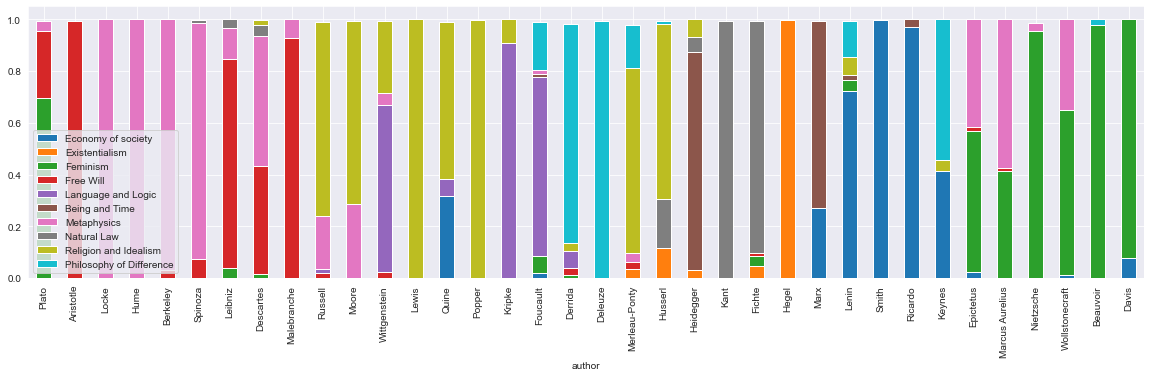

In [78]:
plt.rcParams["figure.figsize"] = (20,5)
Distribution_topic_author.plot.bar(stacked=True)
plt.legend()
plt.show()

With this topic modeling, we manage to transfrom our unstructured data into a structured data. As for the emotional analysis, we can use some typical unsupervised clustering algorithm to detect patterns from the topic modeling. Here we don't use a PCA projection but instead use a dimensionality reduction with the TSNE of the sklearn package. This enable us to see the local clusters inside the data but the global "shape" of our data is flawed. The legend on the left correspond to the most represented topics in the cluster in comparaison to other clusters. According to this topic modeling, Nietzsche and Plato address similar topics wich can be related to Love with word like "Man", "Woman", "Life", "Love" and "Know". Heiddeger and Marx are writing about the Being and the Time with notable words like "Time", "Being", "Dasein" and "Mean". Kant and Fitche are adressing the question of Natural Law whose relevant words are "Nature", "Law", "Principle", "Concept" and "Reason". We should note that the topics distrbution of this topic modeling is only weakly related to school affiliation. This would be sort of excepted since two philosophers from different schools can aboard the same topics but in different ways.

Text(0.5, 1.0, 't-SNE visualization for Topic Modeling')

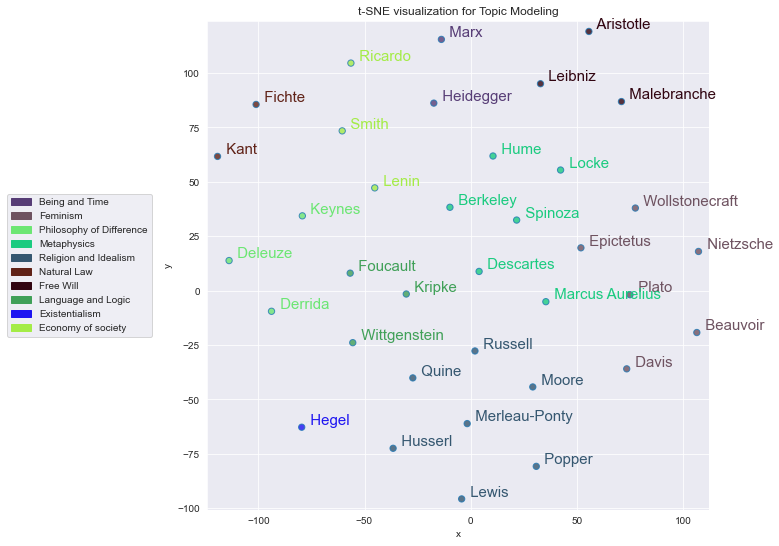

In [75]:
random_state = 150
Y = TSNE(n_components=2, random_state=10).fit_transform(Distribution_topic_author)
KMean = cluster.KMeans(n_clusters = 10, random_state=random_state, algorithm="auto")
Fitted_Cluster = KMean.fit_predict(Distribution_topic_author)
school_color = {'plato':"red", 'aristotle':"blue", 'empiricism':"yellow", 'rationalism':"green", 'analytic':"pink",
       'continental':"lightblue", 'phenomenology':"grey", 'german_idealism': "black", 'communism' : "purple",
       'capitalism' : "pink", 'stoicism' : "darkblue", 'nietzsche' : "brown", 'feminism' : "beige"}
    
# Sets everything up to plot
df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': Distribution_topic_author.index,
                       'cluster' : Fitted_Cluster,
                       'schools' : philosophy_sentences.groupby("author",sort=False).school.unique()
                       })

color_mapping = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(10)]
df["color"] = df["cluster"].apply(lambda x: color_mapping[x])
topic_per_cluster = (
    (Distribution_topic_author.join(df["cluster"])).groupby("cluster").mean()
    -(Distribution_topic_author.join(df["cluster"])).groupby("cluster").mean().mean()
    ).T.idxmax()


fig, _ = plt.subplots()
fig.set_size_inches(9, 9)
    
# Basic plot
p1 = sns.regplot(data=df,
                    x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

# Adds annotations one by one with a loop
for line in range(0, df.shape[0]):
    p1.text(df["x"][line],
        df['y'][line],
        '  ' + df["words"][line].title(),
        horizontalalignment='left',
        verticalalignment='bottom', size='medium',
        color=df['color'][line],
        weight='normal'
        ).set_size(15)

patches = [Patch(color = color) for color in color_mapping]
p1.legend(patches,  list(topic_per_cluster), loc='center right', bbox_to_anchor=(-0.1, 0.5))

plt.xlim(Y[:, 0].min()-5, Y[:, 0].max()+5)
plt.ylim(Y[:, 1].min()-5, Y[:, 1].max()+5)
            
plt.title('t-SNE visualization for Topic Modeling')

Finally, we can proceed to some word embeddings to see the relation between the words used by the philosophers. In other words, this gives us the context in which the word is used. One interesting point which is not discussed further in this blog is to train our word embeddings map separately for each author and see in what context each of them use a common word. Here, we will only at the relationship between the 10 most used word of each author using a Word2Vec embedding from the gensim package.

In [84]:
# Contstruct the Word2Vec model
w2v_model = gensim.models.Word2Vec(min_count=20,
                     window=3,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed=0)
t = time.time()

# Build the vocabulary of the Word2Vec model
w2v_model.build_vocab(tokenized, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

INFO - 00:38:27: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2022-02-08T00:38:27.106815', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
INFO - 00:38:27: collecting all words and their counts
INFO - 00:38:27: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 00:38:27: PROGRESS: at sentence #10000, processed 79260 words, keeping 6954 word types
INFO - 00:38:27: PROGRESS: at sentence #20000, processed 168342 words, keeping 8905 word types
INFO - 00:38:27: PROGRESS: at sentence #30000, processed 283704 words, keeping 12598 word types
INFO - 00:38:27: PROGRESS: at sentence #40000, processed 409185 words, keeping 14278 word types
INFO - 00:38:27: PROGRESS: at sentence #50000, processed 520006 words, keeping 16198 word types
INFO - 00:38:27: PROGRESS: at sentence #60000, processed 637020 words, keeping 2

Time to build vocab: 0.02 mins


In [85]:
t = time.time()
# Train the Word2Vec model on our corpus
w2v_model.train(tokenized, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

INFO - 00:38:28: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 9636 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3 shrink_windows=True', 'datetime': '2022-02-08T00:38:28.992666', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
INFO - 00:38:30: EPOCH 1 - PROGRESS: at 36.54% examples, 511367 words/s, in_qsize 13, out_qsize 0
INFO - 00:38:31: EPOCH 1 - PROGRESS: at 59.97% examples, 459749 words/s, in_qsize 13, out_qsize 0
INFO - 00:38:32: EPOCH 1 - PROGRESS: at 85.50% examples, 449080 words/s, in_qsize 13, out_qsize 0
INFO - 00:38:32: worker thread finished; awaiting finish of 6 more threads
INFO - 00:38:32: worker thread finished; awaiting finish of 5 more threads
INFO - 00:38:32: worker thread finished; awaiting finish of 4 more threads
INFO - 00:38:32: worker thread finished; awaiting finish of 3 more threads
INFO - 00:38:32:

Time to train the model: 1.32 mins


Once our model is trained, we retrieve the top 7 most used words per author.

In [82]:
# Retrieved the tokenized books of each author
Books_per_Authors = sentences_processed.groupby("author", sort=False).apply(lambda x: x.str.cat(sep=" ")).apply(nltk.word_tokenize)
# Calculate the frequencies of apparition of each word in each book of each author
Word_Frequencies_per_Author = Books_per_Authors.apply(nltk.FreqDist)
# Keep the seven most frequent used words per author.
Top_Words_per_Author = Word_Frequencies_per_Author.apply(lambda dict: list(dict)[:7])

We plot below the result of our word embeddings. To do so, we perfom a first dimensionality reduction from 300 to 50 dimensions with a PCA and then project this mapping with a t-SNE dimensionalty reduction. This allow us to keep a "good" global shape of the word embedding as well as a "good" local shape of the word embedding. If two authors have a common favorite words in their most used 7 words, then this word will be displayed in a bigger size. We can see some pattern in the usage of certain words. For instance, the word "black" is similar to the sense "white" in the sense that these two words appears in the "same" sentences. But the word "black" is closer in term of distance to the word "worker", "slave" and "strugle" suggesting that the word "black" is more frequently used in this context. This is even more the case for the word "woman". This cluster might refer to the social political issue that has been going on for centuries.<br />One othe notable cluster is the link to the capitalism with words like "Capital", "Profit" and "Wage". This bag of words is set far away from the rest of the cluster suggesting they only appear in this specific context that is talking about "Capitalism". <br />The word "Man" is linked to the word "God". This suggests that when we talk about God, we must always come back to the human being in the end. The word "Man" is also set against the word "Nature" both being at equidistance to the word "God". But the "Man" can be "Evil" or "Good" whereas the "Nature" is driven by "Laws" and seek "Order" as would suggest the respective proximity to each of those words.

0.848026130348444


Text(0.5, 1.0, 't-SNE visualization for the Word Embedding of the 7 most used words per author')

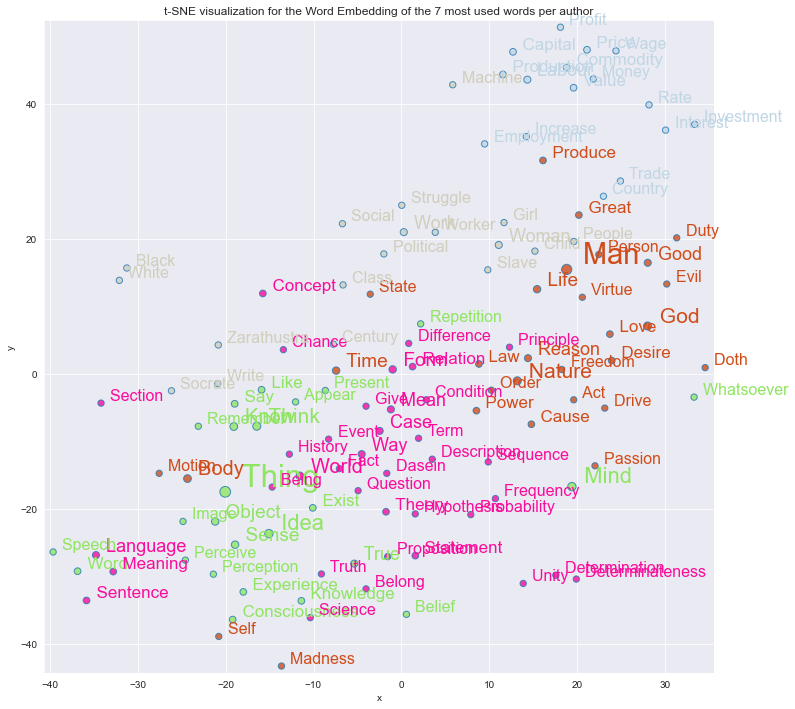

In [97]:
""" Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
import random
arrays = np.empty((0, 300), dtype='f')
word_labels = {}
color_list = []
for author in Top_Words_per_Author.index:
    for word in Top_Words_per_Author[author]:
        if word not in list(word_labels) :
            wrd_vector = w2v_model.wv.__getitem__([word])
            word_labels[word] = 1
            arrays = np.append(arrays, wrd_vector, axis=0)
        else :
            word_labels[word] +=1
# Reduces the dimensionality from 300 to 75 dimensions with PCA
reduc = decomposition.PCA(n_components=50).fit_transform(arrays)
print(sum(decomposition.PCA(n_components=50).fit(arrays).explained_variance_ratio_))
    
# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)
Y = TSNE(n_components=2, random_state=0, perplexity=10).fit_transform(reduc)

# Construct clusters of words
random_state = 150
N_Clusters = 5
KMean = cluster.KMeans(n_clusters = N_Clusters, random_state=random_state, algorithm="auto")
Fitted_Cluster = KMean.fit_predict(arrays)
    
# Sets everything up to plot
df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': list(word_labels),
                       'cluster' : Fitted_Cluster,
                       'size' : word_labels.values()
                       })

color_mapping = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(N_Clusters)]
df["color"] = df["cluster"].apply(lambda x: color_mapping[x])

    
fig, _ = plt.subplots()
fig.set_size_inches(12, 12)
    
# Basic plot
p1 = sns.regplot(data=df,
                    x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 5*df["size"]+35,
                                  'facecolors': df['color']
                                 }
                    )
    
# Adds annotations one by one with a loop
for line in range(0, df.shape[0]):
    p1.text(df["x"][line],
        df['y'][line],
        '  ' + df["words"][line].title(),
        horizontalalignment='left',
        verticalalignment='bottom', size="medium",
        color=df['color'][line],
        weight='normal'
        ).set_size(df["size"][line]+15)
 
plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)
            
plt.title('t-SNE visualization for the Word Embedding of the 7 most used words per author')